In [18]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.decomposition import RandomizedPCA
from sklearn.decomposition import SparsePCA
from sklearn.preprocessing import scale
from sklearn.preprocessing import StandardScaler
from src.utils import load_data_template
from src.features.games import GameFeatures
import matplotlib.pyplot as plt
%matplotlib inline

In [19]:
teams = pd.read_csv('data/Teams.csv')
teams.head()

,TeamID,TeamName,FirstD1Season,LastD1Season
0,1101,Abilene Chr,2014,2018
1,1102,Air Force,1985,2018
2,1103,Akron,1985,2018
3,1104,Alabama,1985,2018
4,1105,Alabama A&M,2000,2018


In [20]:
seasons = pd.read_csv('data/Seasons.csv')
seasons.head()

,Season,DayZero,RegionW,RegionX,RegionY,RegionZ
0,1985,10/29/1984,East,West,Midwest,Southeast
1,1986,10/28/1985,East,Midwest,Southeast,West
2,1987,10/27/1986,East,Southeast,Midwest,West
3,1988,11/2/1987,East,Midwest,Southeast,West
4,1989,10/31/1988,East,West,Midwest,Southeast


In [21]:
seeds = pd.read_csv('data/NCAATourneySeeds.csv')
seeds.head()

,Season,Seed,TeamID
0,1985,W01,1207
1,1985,W02,1210
2,1985,W03,1228
3,1985,W04,1260
4,1985,W05,1374


In [22]:
season_results = pd.read_csv('data/RegularSeasonCompactResults.csv')
season_results.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT
0,1985,20,1228,81,1328,64,N,0
1,1985,25,1106,77,1354,70,H,0
2,1985,25,1112,63,1223,56,H,0
3,1985,25,1165,70,1432,54,H,0
4,1985,25,1192,86,1447,74,H,0


In [23]:
tournament_results = pd.read_csv('data/NCAATourneyCompactResults.csv')
tournament_results.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT
0,1985,136,1116,63,1234,54,N,0
1,1985,136,1120,59,1345,58,N,0
2,1985,136,1207,68,1250,43,N,0
3,1985,136,1229,58,1425,55,N,0
4,1985,136,1242,49,1325,38,N,0


In [24]:
rankings = pd.read_csv('data/MasseyOrdinals.csv',dtype={'Season':'str',
                                                        'TeamID':'str'})
rankings.head()

,Season,RankingDayNum,SystemName,TeamID,OrdinalRank
0,2003,35,SEL,1102,159
1,2003,35,SEL,1103,229
2,2003,35,SEL,1104,12
3,2003,35,SEL,1105,314
4,2003,35,SEL,1106,260


----

------

---

In [25]:
df = rankings.pivot_table(values = 'OrdinalRank', 
                     index = ['Season', 'RankingDayNum', 'TeamID'], 
                     columns = 'SystemName').fillna(0).reset_index()
print(df.shape)
df.sample()

(211603, 162)


SystemName,Season,RankingDayNum,TeamID,7OT,ACU,ADE,AP,ARG,AUS,BBT,...,UPS,USA,WIL,WLK,WMR,WOB,WOL,WTE,YAG,ZAM
92242,2008,120,1164,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,280.0,0.0,291.0,0.0,0.0,0.0,0.0


In [26]:
df.iloc[:, :3].values

array([['2003', 35, '1102'],
       ['2003', 35, '1103'],
       ['2003', 35, '1104'],
       ..., 
       ['2017', 133, '1462'],
       ['2017', 133, '1463'],
       ['2017', 133, '1464']], dtype=object)

In [27]:
df.tail()

SystemName,Season,RankingDayNum,TeamID,7OT,ACU,ADE,AP,ARG,AUS,BBT,...,UPS,USA,WIL,WLK,WMR,WOB,WOL,WTE,YAG,ZAM
211598,2017,133,1460,157.0,0.0,121.0,0.0,131.0,0.0,165.0,...,0.0,0.0,130.0,165.0,0.0,132.0,130.0,0.0,171.0,175.0
211599,2017,133,1461,181.0,0.0,150.0,0.0,148.0,0.0,156.0,...,0.0,0.0,120.0,151.0,0.0,128.0,146.0,0.0,127.0,143.0
211600,2017,133,1462,45.0,0.0,38.0,0.0,38.0,0.0,51.0,...,0.0,0.0,34.0,46.0,0.0,39.0,38.0,0.0,37.0,39.0
211601,2017,133,1463,123.0,0.0,116.0,0.0,127.0,0.0,138.0,...,0.0,0.0,144.0,135.0,0.0,148.0,132.0,0.0,150.0,172.0
211602,2017,133,1464,317.0,0.0,275.0,0.0,271.0,0.0,294.0,...,0.0,0.0,254.0,291.0,0.0,255.0,257.0,0.0,285.0,283.0


In [114]:
df_ri = df.reset_index()

In [115]:
df_ri.tail()

SystemName,Season,RankingDayNum,TeamID,7OT,ACU,ADE,AP,ARG,AUS,BBT,...,UPS,USA,WIL,WLK,WMR,WOB,WOL,WTE,YAG,ZAM
211598,2017,133,1460,157.0,0.0,121.0,0.0,131.0,0.0,165.0,...,0.0,0.0,130.0,165.0,0.0,132.0,130.0,0.0,171.0,175.0
211599,2017,133,1461,181.0,0.0,150.0,0.0,148.0,0.0,156.0,...,0.0,0.0,120.0,151.0,0.0,128.0,146.0,0.0,127.0,143.0
211600,2017,133,1462,45.0,0.0,38.0,0.0,38.0,0.0,51.0,...,0.0,0.0,34.0,46.0,0.0,39.0,38.0,0.0,37.0,39.0
211601,2017,133,1463,123.0,0.0,116.0,0.0,127.0,0.0,138.0,...,0.0,0.0,144.0,135.0,0.0,148.0,132.0,0.0,150.0,172.0
211602,2017,133,1464,317.0,0.0,275.0,0.0,271.0,0.0,294.0,...,0.0,0.0,254.0,291.0,0.0,255.0,257.0,0.0,285.0,283.0


### Performing PCA Analysis

In [116]:
pca = PCA()
X = df.values
pca = PCA(n_components=20)
X_pca = pca.fit_transform(X)

In [117]:
print(pca.explained_variance_)

[ 166500.22317783   51609.22446531   31537.50859837   24555.82661916
   18043.48247291   14132.0171741    11262.57224976    9058.39496446
    8365.54135605    7625.67937685    7111.69864676    6496.6103567
    5993.58695744    5850.10951181    5471.61476376    5275.2056239
    5159.84536251    4640.4942889     4221.60152149    4000.96346004]


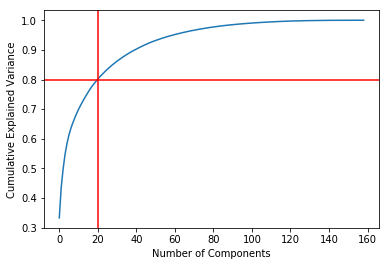

In [118]:
pca_plot = PCA().fit(X)
plt.plot(np.cumsum(pca_plot.explained_variance_ratio_))
plt.axhline(y=0.8, color = 'r')
plt.axvline(x=20, color = 'r')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance');

### We can add more variables but the first 20 PC seem to capture most of the variance

In [119]:
X_std = StandardScaler().fit_transform(X)

In [120]:
X_std.T

array([[ -0.32263556,  -0.32263556,  -0.32263556, ...,   0.33726268,
          1.48108629,   4.32598091],
       [ -0.24187829,  -0.24187829,  -0.24187829, ...,  -0.24187829,
         -0.24187829,  -0.24187829],
       [ -0.25363683,  -0.25363683,  -0.25363683, ...,   0.43348994,
          1.84390805,   4.71899112],
       ..., 
       [ -0.05911436,  -0.05911436,  -0.05911436, ...,  -0.05911436,
         -0.05911436,  -0.05911436],
       [ -0.03531853,  -0.03531853,  -0.03531853, ...,   4.44084977,
         18.11130972,  34.44327515],
       [ -0.07917241,  -0.07917241,  -0.07917241, ...,   2.03612033,
          9.24981092,  15.27025947]])

In [121]:
mean_vec = np.mean(X_std, axis=0)
cov_mat = (X_std - mean_vec).T.dot((X_std - mean_vec)) / (X_std.shape[0]-1)
pd.DataFrame(cov_mat, columns=rankings.SystemName.unique(),)

,SEL,AP,BIH,DUN,ENT,GRN,IMS,MAS,MKV,MOR,...,SMS,HKS,MUZ,OCT,SGR,ZAM,JNG,CRW,PMC,YAG
0,1.000005,0.522878,0.339502,-0.037963,0.243275,-0.034059,0.772841,-0.043148,-0.061367,0.517205,...,0.261937,-0.037895,0.443796,0.480193,0.526265,0.317400,0.399761,-0.019072,0.108212,0.189467
1,0.522878,1.000005,-0.036450,-0.026004,0.182753,-0.025534,0.590931,-0.021934,-0.038379,0.334409,...,-0.020809,-0.025988,0.368176,0.313814,0.523275,0.259560,0.238285,-0.014299,-0.008543,-0.019150
2,0.339502,-0.036450,1.000005,-0.031987,0.017483,-0.026775,0.339457,-0.033921,-0.048243,0.187007,...,0.336576,-0.032106,0.328866,0.262951,0.300087,0.147903,0.200164,-0.014994,0.137312,0.243294
3,-0.037963,-0.026004,-0.031987,1.000005,-0.033831,-0.013028,-0.042540,-0.020528,-0.019244,-0.066993,...,-0.010353,0.872261,-0.069758,-0.071110,-0.024702,-0.052559,-0.071637,-0.007585,-0.004515,-0.009992
4,0.243275,0.182753,0.017483,-0.033831,1.000005,-0.028560,0.297104,0.032648,0.482667,0.240615,...,-0.023276,-0.033554,0.218175,0.356261,-0.032948,0.415803,0.336077,0.209078,0.134750,0.302684
5,-0.034059,-0.025534,-0.026775,-0.013028,-0.028560,1.000005,-0.037216,-0.014118,-0.020079,0.004343,...,-0.009082,-0.013010,0.055409,0.122082,-0.022540,0.113380,0.000504,-0.006240,-0.003728,-0.008358
6,0.772841,0.590931,0.339457,-0.042540,0.297104,-0.037216,1.000005,-0.047147,-0.067054,0.501740,...,0.240997,-0.042461,0.542706,0.502776,0.599701,0.329227,0.372076,-0.020840,0.099452,0.223797
7,-0.043148,-0.021934,-0.033921,-0.020528,0.032648,-0.014118,-0.047147,1.000005,0.072044,0.017044,...,-0.011506,-0.020551,-0.008913,-0.021831,-0.028555,-0.012208,0.012052,-0.007906,-0.004723,-0.010588
8,-0.061367,-0.038379,-0.048243,-0.019244,0.482667,-0.020079,-0.067054,0.072044,1.000005,0.037028,...,-0.016364,-0.018930,-0.011528,0.255473,-0.040612,0.376863,0.104020,-0.011244,-0.006718,-0.015059
9,0.517205,0.334409,0.187007,-0.066993,0.240615,0.004343,0.501740,0.017044,0.037028,1.000005,...,0.135257,-0.066574,0.390026,0.468623,0.347340,0.403716,0.425325,0.062317,0.071004,0.159405


In [122]:
cov_mat = np.cov(X_std.T)

eig_vals, eig_vecs = np.linalg.eig(cov_mat)

print('Eigenvectors \n%s' %eig_vecs)
print('\nEigenvalues \n%s' %eig_vals)

Eigenvectors 
[[ 0.13914525 -0.05020967 -0.08176755 ...,  0.06978177 -0.03874517
  -0.00053525]
 [ 0.09353535 -0.05273486 -0.09844415 ...,  0.2242554  -0.22287292
   0.07038524]
 [ 0.07223213 -0.06293399 -0.0348367  ..., -0.0890644   0.04043205
   0.11743741]
 ..., 
 [-0.00046531 -0.00359275  0.04501474 ..., -0.01547022 -0.00143928
   0.00192625]
 [ 0.03804096  0.0940407   0.03888716 ...,  0.01057616  0.00718927
   0.00413944]
 [ 0.07565268  0.16599219  0.06139744 ...,  0.07322728  0.0515778
  -0.02628552]]

Eigenvalues 
[  3.12249651e+01   1.29924201e+01   9.00264878e+00   7.04960360e+00
   5.15891560e+00   4.63739413e+00   4.45967468e+00   3.72280781e+00
   3.32852249e+00   2.99063762e+00   2.78946841e+00   2.46130960e+00
   2.23004839e+00   2.17589203e+00   2.08810638e+00   2.04176194e+00
   1.89686660e+00   1.77178675e+00   1.73377297e+00   1.64627404e+00
   1.57731606e+00   1.45532850e+00   1.35801975e+00   1.29419422e+00
   1.24293828e+00   1.18360248e+00   1.20146611e+00   1.165

In [60]:
import importlib
import src
importlib.reload(src)
importlib.reload(src.features.rankings)
from src.features.rankings import RankingFeatures
from src.utils import load_data_template
data = load_data_template()
data.dropna(inplace=True)
ranking_detail_feat = RankingFeatures(default_lags=3)
data = ranking_detail_feat.per_team_wrapper(data, ranking_detail_feat.pca_variables_rankings, per_day=True)

print(data.shape)
data.sample()

(2117, 167)


,Season,team_a,team_b,in_target,game_set,a_win,DayNum,PC1_team_a,PC2_team_a,PC3_team_a,...,PC17_team_b_lag-3,PC18_team_b_lag-1,PC18_team_b_lag-2,PC18_team_b_lag-3,PC19_team_b_lag-1,PC19_team_b_lag-2,PC19_team_b_lag-3,PC20_team_b_lag-1,PC20_team_b_lag-2,PC20_team_b_lag-3
9842,1996,1280,1343,False,0,True,138,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
ranking_detail_feat.lag_features(ranking_detail_feat.pca_variables_rankings(data, team="team_a"), drop_unlagged=False)

In [ ]:
from src.features.

In [88]:
X_pca.shape

(211603, 20)

In [99]:
df_pca = pd.DataFrame(X_pca, columns=['PC' + str(pcs+1) for pcs in np.arange(X_pca.shape[1])])
df_pca.sample()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20
100652,-230.965814,-130.639197,64.567445,-114.543618,10.98057,-74.222099,37.613462,-9.421023,28.051788,36.275838,16.350346,-26.343211,-52.072158,64.923406,60.422248,63.814846,47.917982,-62.086218,-119.264753,108.546769


In [95]:
columns = [[i for i in data.columns], ['PC' + str(pcs+1) for pcs in np.arange(X_pca.shape[1])]]

In [71]:
data.shape

(77617, 85)

In [60]:
X_pca.shape

(211603, 20)

In [63]:
df_ri.shape

(211603, 162)

In [66]:
df_ri.head()

SystemName,Season,RankingDayNum,TeamID,7OT,ACU,ADE,AP,ARG,AUS,BBT,...,UPS,USA,WIL,WLK,WMR,WOB,WOL,WTE,YAG,ZAM
0,2003,35,1102,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2003,35,1103,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2003,35,1104,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2003,35,1105,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2003,35,1106,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [124]:
df_pca = pd.DataFrame(X_pca, columns = ['PC' + str(pcs+1) for pcs in np.arange(X_pca.shape[1])])

In [126]:
df_pca.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20
0,-267.131723,-46.374835,-69.369661,42.617893,-37.151943,43.549939,16.277456,-5.941923,-30.042421,-15.027836,17.825586,34.556677,74.234314,4.348643,4.533346,-41.649164,8.082587,-29.858810,-27.449009,2.883854
1,-259.354670,-51.269227,-64.989665,49.288993,-47.049522,52.403137,19.864622,-16.381433,-49.514985,-22.902079,29.945028,53.665826,109.195689,16.456628,6.268666,-59.230951,12.592138,-43.326625,-40.208719,2.171756
2,-283.463534,-36.096612,-78.567652,28.608581,-16.367025,24.958224,8.744409,15.981047,10.849964,1.508075,-7.625241,-5.572535,0.815428,-21.078125,0.889174,-4.727411,-1.387469,-1.576399,-0.653618,4.379260
3,-249.911105,-57.212417,-59.671099,57.389615,-59.068012,63.153449,24.220465,-29.057981,-73.160242,-32.463660,44.661492,76.869793,151.648787,31.159181,8.375840,-80.580264,18.068021,-59.680401,-55.702652,1.307065
4,-255.910546,-53.436744,-63.049953,52.243338,-51.432736,56.323839,21.453223,-21.004644,-58.138549,-26.389244,35.312209,62.128449,124.678584,21.818736,7.037165,-67.017171,14.589225,-49.290943,-45.859447,1.856398


In [137]:
df.tail()

SystemName                     7OT  ACU    ADE   AP    ARG  AUS    BBT  BCM  \
Season RankingDayNum TeamID                                                   
2017   133           1460    157.0  0.0  121.0  0.0  131.0  0.0  165.0  0.0   
                     1461    181.0  0.0  150.0  0.0  148.0  0.0  156.0  0.0   
                     1462     45.0  0.0   38.0  0.0   38.0  0.0   51.0  0.0   
                     1463    123.0  0.0  116.0  0.0  127.0  0.0  138.0  0.0   
                     1464    317.0  0.0  275.0  0.0  271.0  0.0  294.0  0.0   

SystemName                    BD    BIH  ...    UPS  USA    WIL    WLK  WMR  \
Season RankingDayNum TeamID              ...                                  
2017   133           1460    0.0  134.0  ...    0.0  0.0  130.0  165.0  0.0   
                     1461    0.0  136.0  ...    0.0  0.0  120.0  151.0  0.0   
                     1462    0.0   40.0  ...    0.0  0.0   34.0   46.0  0.0   
                     1463    0.0  133.0  ...    0.0  0.0  144.0  135.0  0.0   
                     1464    0.0  261.0  ...    0.0  0.0  254.0  291.0  0.0   

SystemName                     WOB    WOL  WTE    YAG    ZAM  
Season RankingDayNum TeamID                                   
2017   133           1460    132.0  130.0  0.0  171.0  175.0  
                     1461    128.0  146.0  0.0  127.0  143.0  
                     1462     39.0   38.0  0.0   37.0   39.0  
                     1463    148.0  132.0  0.0  150.0  172.0  
                     1464    255.0  257.0  0.0  285.0  283.0  

[5 rows x 159 columns]

In [136]:
df_pca.tail()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20
211598,709.549637,-302.060763,-149.092633,466.984444,-157.848770,-217.800726,-77.256600,93.065354,-48.339150,-139.063562,-65.139086,-107.958365,-51.840985,6.884609,-37.373989,-123.979811,57.317170,-36.248500,65.808365,-143.119661
211599,710.300637,-328.949969,-136.953931,426.479739,-189.422213,-196.811177,-98.712436,108.442197,-27.879848,-141.690148,-61.393786,-87.517060,-55.957450,2.820781,-52.603163,-106.829861,71.116089,-49.311877,59.942685,-153.278239
211600,-3.353942,-126.383731,-98.633064,144.169780,-76.162890,-50.438820,-28.766963,30.563160,1.303161,-48.238773,-22.989071,-19.945556,-32.709620,-22.332288,-11.352851,-19.192807,10.606037,-11.514278,14.865834,-40.112714
211601,637.286030,-297.813956,-121.581983,436.063750,-200.094865,-194.350863,-67.468721,94.411448,-39.223519,-143.221999,-50.790312,-99.318905,-39.980159,29.939706,-55.705849,-117.652829,54.561462,-23.809761,48.603914,-102.486214
211602,1541.746266,-515.907492,-195.729916,818.428723,-338.077023,-387.323934,-168.680244,165.262404,-122.359607,-276.736207,-97.453496,-154.081979,-92.315693,10.429980,-102.066066,-241.173861,88.533644,-40.844638,162.959633,-241.985137


In [130]:
print(df_pca.shape, df.shape)

(211603, 20) (211603, 159)


In [134]:
pd.concat([df.reset_index(), df_pca.reset_index()], axis = 1)

,Season,RankingDayNum,TeamID,7OT,ACU,ADE,AP,ARG,AUS,BBT,...,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20
0,2003,35,1102,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,17.825586,34.556677,74.234314,4.348643,4.533346,-41.649164,8.082587,-29.858810,-27.449009,2.883854
1,2003,35,1103,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,29.945028,53.665826,109.195689,16.456628,6.268666,-59.230951,12.592138,-43.326625,-40.208719,2.171756
2,2003,35,1104,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-7.625241,-5.572535,0.815428,-21.078125,0.889174,-4.727411,-1.387469,-1.576399,-0.653618,4.379260
3,2003,35,1105,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,44.661492,76.869793,151.648787,31.159181,8.375840,-80.580264,18.068021,-59.680401,-55.702652,1.307065
4,2003,35,1106,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,35.312209,62.128449,124.678584,21.818736,7.037165,-67.017171,14.589225,-49.290943,-45.859447,1.856398
5,2003,35,1107,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,33.407725,59.125583,119.184653,19.916052,6.764472,-64.254319,13.880581,-47.174572,-43.854350,1.968299
6,2003,35,1108,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,29.771893,53.392839,108.696241,16.283657,6.243876,-58.979783,12.527716,-43.134228,-40.026437,2.181929
7,2003,35,1110,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,25.616656,46.841130,96.709484,12.132348,5.648909,-52.951742,10.981584,-38.516691,-35.651679,2.426077
8,2003,35,1111,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,21.980823,41.108386,86.221071,8.499952,5.128313,-47.677206,9.628719,-34.476347,-31.823767,2.639706
9,2003,35,1112,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-5.201353,-1.750706,7.807703,-18.656528,1.236238,-8.243769,-0.485559,-4.269962,-3.205560,4.236840


In [129]:
data.describe()

,game_set,FGM_game_team_a_lag-1,FGM_game_team_a_lag-2,FGM_game_team_a_lag-3,FGA_game_team_a_lag-1,FGA_game_team_a_lag-2,FGA_game_team_a_lag-3,FGM3_game_team_a_lag-1,FGM3_game_team_a_lag-2,FGM3_game_team_a_lag-3,...,TO_game_team_b_lag-3,Stl_game_team_b_lag-1,Stl_game_team_b_lag-2,Stl_game_team_b_lag-3,Blk_game_team_b_lag-1,Blk_game_team_b_lag-2,Blk_game_team_b_lag-3,PF_game_team_b_lag-1,PF_game_team_b_lag-2,PF_game_team_b_lag-3
count,77617.000000,77617.000000,77617.000000,77617.000000,77617.000000,77617.000000,77617.000000,77617.000000,77617.000000,77617.000000,...,77617.000000,77617.000000,77617.000000,77617.000000,77617.000000,77617.000000,77617.000000,77617.000000,77617.000000,77617.000000
mean,0.987361,24.150650,24.158870,24.151475,55.539250,55.531958,55.522759,6.467076,6.470683,6.472422,...,13.708092,6.539134,6.551129,6.551374,3.362073,3.366131,3.358839,18.637219,18.635067,18.629914
std,0.111711,4.868871,4.860452,4.874180,7.675314,7.671153,7.689649,2.923393,2.926220,2.937044,...,4.320940,3.019224,3.022082,3.019463,2.312918,2.320408,2.320492,4.495558,4.512966,4.512138
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,3.000000,3.000000
25%,1.000000,21.000000,21.000000,21.000000,50.000000,50.000000,50.000000,4.000000,4.000000,4.000000,...,11.000000,4.000000,4.000000,4.000000,2.000000,2.000000,2.000000,16.000000,16.000000,15.000000
50%,1.000000,24.000000,24.000000,24.000000,55.000000,55.000000,55.000000,6.000000,6.000000,6.000000,...,13.000000,6.000000,6.000000,6.000000,3.000000,3.000000,3.000000,18.000000,18.000000,18.000000
75%,1.000000,27.000000,27.000000,27.000000,60.000000,60.000000,60.000000,8.000000,8.000000,8.000000,...,16.000000,8.000000,8.000000,8.000000,5.000000,5.000000,5.000000,22.000000,22.000000,22.000000
max,1.000000,56.000000,56.000000,56.000000,106.000000,106.000000,106.000000,25.000000,25.000000,25.000000,...,41.000000,26.000000,26.000000,26.000000,19.000000,19.000000,19.000000,45.000000,45.000000,45.000000


In [45]:
data.dtypes

Season                                object
team_a                                object
team_b                                object
in_target                               bool
game_set                               int64
a_win                                 object
DayNum                               float64
games_won_in_season_team_a             int64
games_won_in_season_team_a_lag-1     float64
games_won_in_season_team_a_lag-2     float64
games_won_in_season_team_a_lag-3     float64
games_won_in_season_team_b             int64
games_won_in_season_team_b_lag-1     float64
games_won_in_season_team_b_lag-2     float64
games_won_in_season_team_b_lag-3     float64
games_won_in_tourney_team_a_lag-1    float64
games_won_in_tourney_team_a_lag-2    float64
games_won_in_tourney_team_a_lag-3    float64
games_won_in_tourney_team_b_lag-1    float64
games_won_in_tourney_team_b_lag-2    float64
games_won_in_tourney_team_b_lag-3    float64
dtype: object

In [73]:
df.dtypes

SystemName
Season            object
RankingDayNum      int64
TeamID            object
7OT              float64
ACU              float64
ADE              float64
AP               float64
ARG              float64
AUS              float64
BBT              float64
BCM              float64
BD               float64
BIH              float64
BKM              float64
BLS              float64
BNM              float64
BOB              float64
BOW              float64
BP5              float64
BPI              float64
BRZ              float64
BUR              float64
BWE              float64
CJB              float64
CMV              float64
CNG              float64
COL              float64
CPA              float64
CPR              float64
CRO              float64
                  ...   
SIM              float64
SMN              float64
SMS              float64
SP               float64
SPR              float64
SPW              float64
STF              float64
STH              float64
STR           

In [76]:

for team, opponent_team in [('a','b'), ('b','a')]:
    data = pd.merge(data, df,
        left_on=['Season','DayNum','team_{}'.format(team)],
        right_on=['Season','RankingDayNum', 'TeamID'],
        how='left')

In [77]:
data_rk.describe() # Wrong, still not properly merged

,game_set,games_won_in_season_team_a,games_won_in_season_team_a_lag-1,games_won_in_season_team_a_lag-2,games_won_in_season_team_a_lag-3,games_won_in_season_team_b,games_won_in_season_team_b_lag-1,games_won_in_season_team_b_lag-2,games_won_in_season_team_b_lag-3,games_won_in_tourney_team_a_lag-1,...,UPS,USA,WIL,WLK,WMR,WOB,WOL,WTE,YAG,ZAM
count,10961.0,10961.000000,10961.000000,10961.000000,10961.000000,10961.000000,10961.000000,10961.000000,10961.000000,10961.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mean,0.0,23.194690,20.474774,19.988687,19.362376,23.271508,20.640361,19.639449,18.686616,1.058024,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,0.0,3.672776,5.574342,5.949641,6.328915,3.616820,5.607121,5.935704,6.180855,1.465762,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,0.0,11.000000,0.000000,0.000000,0.000000,9.000000,0.000000,0.000000,0.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,0.0,21.000000,17.000000,16.000000,15.000000,21.000000,17.000000,16.000000,15.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,0.0,23.000000,21.000000,21.000000,20.000000,23.000000,21.000000,20.000000,19.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,0.0,25.000000,24.000000,24.000000,24.000000,26.000000,25.000000,24.000000,23.000000,2.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max,0.0,34.000000,34.000000,34.000000,33.000000,34.000000,34.000000,34.000000,33.000000,6.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# TODO:

- Select the first 20 PCAs
- Properly append/merge for team_a and team_b using team_wrapper
-----------
- Create the RandomizedPCA variables
- Create the sparse_pca variables
